<a href="https://colab.research.google.com/github/kodai-utsunomiya/memorization-and-generalization/blob/main/numerical_experiments/1_time_scale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $(k, d)$-Sparse Parity Task

$d$-個の数字の内の $k$ 個の数字のパリティを計算する（$k \le d$）という問題

# データセット

---

- $\mathcal{D}_{k, d} = \{ (\boldsymbol{x}_i , y_i) \}_{i=1}^n$
    - $n$ 個の学習データ
    - $\boldsymbol{x}_i \in \{ 0,1 \}^d$：バイナリーベクトル．$\boldsymbol{x}_i \sim \text{Unif} \left( \{0,1\}^d \right)$
    - $y_i = \left(\sum_{i}^k x^{(i)} \right) \text{mod} \hspace{2mm} 2$ ：最初の $k$  個の数字（clean digits）のパリティ

<br>

  - $\boldsymbol{x}_i$ の残りの $d-k$ 個の数字（noisy digits）は $y_i$ とは無関係

<br>

- 例：
    - $(3, 30)$-sparse parity dataset
        - $\boldsymbol{x}_1$：<font color="blue">000</font>$110010110001010111001001011$，  $y_1 = 0$
        - $\boldsymbol{x}_2$：<font color="blue">010</font>$110010110001010111001001011$，  $y_2 = 1$
            
            $\hspace{2mm} \vdots$
            

<br>

- 学習データをまとめて，$\mathcal{X} = \left[ \boldsymbol{x}_1, \ldots, \boldsymbol{x}_n \right] \in \mathbb{R}^{n \times d}$，$\mathcal{Y} = \left[ y_1 \ldots, y_n \right] \in \mathbb{R}^n$ と行列表記

In [176]:
import numpy as np
import torch
from torch.utils.data import Dataset, Subset

def _generate_unique_binary_strings(n, total_size, data_seed):
    """
    ユニークなバイナリ文字列を生成する関数

    Parameters:
    - n: バイナリ文字列の長さ
    - total_size: 必要なユニークなバイナリ文字列の数
    - data_seed: ランダムシード

    Returns:
    - list: ユニークなバイナリ文字列のリスト．各バイナリ文字列は長さ n のタプル
    """
    np.random.seed(data_seed)
    unique_binary_strings = set()

    # 必要な数のユニークなバイナリ文字列が得られるまで繰り返す
    while len(unique_binary_strings) < total_size:
        binary_string = tuple(np.random.randint(2, size=n))
        unique_binary_strings.add(binary_string)
    return list(unique_binary_strings)

def _prepare_data(binary_strings, k):
    """
    入力データと出力ラベルを準備する関数

    Parameters:
    - binary_strings: バイナリ文字列のリスト．各バイナリ文字列は長さ n のタプル
    - k: 出力ラベルの計算に使用する最初の k 個のビット

    Returns:
    - tuple: (入力データ, 出力ラベル)
      - 入力データ: バイナリ文字列を NumPy 配列として保持し，最後にバイアス列を追加
      - 出力ラベル: 最初の k ビットの合計の 2 で割った余りとして計算
    """
    # バイナリ文字列をNumPy配列に変換
    inputs = np.array(binary_strings, dtype=np.float32)

    # 出力ラベルを計算 (最初の k ビットの合計を 2 で割った余り)
    outputs = np.sum(inputs[:, :k], axis=-1) % 2

    # 出力ラベルを 0 -> -1, 1 -> 1 に変換（ヒンジ損失用）
    outputs = 2 * outputs - 1

    return inputs, outputs

def _normalize_data(inputs):
    """
    データの中心化と標準化を行うヘルパー関数

    Parameters:
    - inputs: 正規化対象の入力データ (NumPy配列)

    Returns:
    - 正規化された入力データ
    """
    # NumPy配列をPyTorchテンソルに変換
    inputs = torch.tensor(inputs, dtype=torch.float32)

    # 1. データの中心化（平均を0に）
    inputs = inputs - inputs.mean(dim=0)

    # 2. 標準化（各サンプルのノルムで割る）．データが単位ノルムを持つようにスケーリングされる
    norm = inputs.flatten(1).norm(dim=1).view(-1, *(1,) * (inputs.dim() - 1))
    inputs = (inputs[0].numel() ** 0.5) * inputs / norm

    return inputs.numpy()  # NumPy配列に戻す

def get_binary_dataset(n, k, train_size, test_size, data_seed, normalize=False, device=None):
    """
    二値分類用にデータセットを取得する関数

    Parameters:
    - n: バイナリ文字列の長さ
    - k: 出力ラベルの計算に使用する最初の k 個のビット
    - train_size: 訓練データのサイズ
    - test_size: テストデータのサイズ
    - data_seed: ランダムシード
    - normalize: データを正規化するかどうかを示すフラグ
    - device: データを移動するデバイス

    Returns:
    - tuple: ((訓練データのx, 訓練データのy), (テストデータのx, テストデータのy))
      - 訓練データのx: 訓練データの入力データ
      - 訓練データのy: 訓練データの出力ラベル
      - テストデータのx: テストデータの入力データ
      - テストデータのy: テストデータの出力ラベル
    """
    total_size = train_size + test_size

    # ユニークなバイナリ文字列を生成
    binary_strings = _generate_unique_binary_strings(n, total_size, data_seed)

    # 入力データと出力ラベルを準備
    inputs, outputs = _prepare_data(binary_strings, k)

    # 正規化を行う場合（中心化と標準化）
    if normalize:
        inputs = _normalize_data(inputs)

    # データのインデックスをシャッフル
    indices = np.random.permutation(total_size)

    # 訓練データとテストデータのインデックスを分割
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    # 訓練データとテストデータをNumPy配列からPyTorchテンソルに変換
    train_inputs = torch.tensor(inputs[train_indices], dtype=torch.float32)
    train_outputs = torch.tensor(outputs[train_indices], dtype=torch.float32)
    test_inputs = torch.tensor(inputs[test_indices], dtype=torch.float32)
    test_outputs = torch.tensor(outputs[test_indices], dtype=torch.float32)

    # データを指定されたデバイスに移動
    if device:
        train_inputs, train_outputs = train_inputs.to(device), train_outputs.to(device)
        test_inputs, test_outputs = test_inputs.to(device), test_outputs.to(device)

    return (train_inputs, train_outputs), (test_inputs, test_outputs)

In [ ]:
a = get_binary_dataset(n=30, k=3, train_size=900, test_size=100, data_seed=42, normalize=False)

In [ ]:
print(f"訓練データのパターン\n", a[0][0].shape)
print(a[0][0])

訓練データのパターン
 torch.Size([900, 30])
tensor([[1., 0., 1.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 0., 1., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 0., 1.],
        [0., 1., 1.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 1., 0., 1.]])


In [ ]:
print(f"訓練データのラベル\n", a[0][1].shape)
print(a[0][1])

訓練データのラベル
 torch.Size([900])
tensor([-1.,  1., -1., -1., -1.,  1.,  1.,  1., -1., -1., -1., -1.,  1., -1.,
        -1., -1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1., -1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,
        -1., -1., -1.,  1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1.,
        -1.,  1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  1.,
        -1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,  1.,
         1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
         1.,  1., -1., -1., -1.,  1., -1.,  1., -1.,  1.,  1., -1., -1., -1.,
        -1., -1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,  1., -1.,  1.,
        -1.,  1.,  1., -1., -1.,  1., -1., -1., -1.,  1., -1.,  1., -1., -1.,
         1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,
         1.,  1., -1., -1., -1., -1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,
        -1., -1., -1., -1., -1.,  1

In [ ]:
a[1][0].shape

torch.Size([100, 30])

In [ ]:
a[1][1].shape

torch.Size([100])

# モデル

---

$ F(\boldsymbol{w}, \boldsymbol{x}) \equiv \alpha \left\lbrack f(\boldsymbol{w}, \boldsymbol{x}) - f(\boldsymbol{w}_0, \boldsymbol{x}) \right\rbrack $ という形をしたモデルの学習を考える（これを予測器として使用し，$\boldsymbol{w}$を学習）

# FCクラス．<font color="green"> $f(\boldsymbol{x})$ の定義 </font>

### ネットワークの構造

1. **入力層**: 次元数 $d$ の入力を受け取る．
2. **隠れ層**: 層数 $L$ の隠れ層があり，各隠れ層のユニット数は $h$．
3. **出力層**: 最終層は出力がスカラー値である 1 次元のベクトルを生成．

<br>

### 層ごとの計算

1. **初期化**:
   - 隠れ層 $i$ の重み行列 $W_i$ は，次のように初期化：
     
     $
     W_i \sim \mathcal{N}(0, 1)
     $

     ここで，$W_i$ のサイズは $ h \times \text{hh}_{i}$ ．
     
     $\text{hh}_{i} $ は前の層の出力ユニット数．

   - メモリ効率を考慮し，重み行列を分割：
     
     \begin{aligned} W_i =  \begin{bmatrix}
        W_i^{(0)} \\
        W_i^{(1)} \\
        \vdots \\
        W_i^{(n-1)}
        \end{bmatrix}  \end{aligned}
     
     各部分行列 $W_i^{(j)}$ はサイズ $m \times \text{hh}_{i}$．ここで，$m$ は分割サイズ．

<br>

2. **順伝播計算**:
   - 入力テンソル $x$ は，初期の隠れ層で次のように変換：
     
     $
     x^{(0)} = x W_0^T / \sqrt{d}
     $

     ここで，$W_0$ は最初の隠れ層の重み行列．バイアス項がある場合，次のように加算：
     
     $
     x^{(0)} = x^{(0)} + b_0
     $

     その後，活性化関数 $ \sigma $ を適用：
     
     $
     x^{(1)} = \sigma(x^{(0)})
     $

   - 次の隠れ層も同様に計算．一般的に，隠れ層 $i$ の計算は次のようになる：
     
     $
     x^{(i)} = x^{(i-1)} W_i^T / \sqrt{h}
     $

     ここで，$W_i$ は現在の層の重み行列．バイアス項がある場合，次のように加算：

     $
     x^{(i)} = x^{(i)} + b_i
     $

     そして，活性化関数を適用：
     
     $
     x^{(i+1)} = \sigma(x^{(i)})
     $

   - 最終層では，次のように計算：
     
     $
     x^{(L)} = x^{(L-1)} W_L^T / \sqrt{h} + b_L
     $
     
     ここで，$W_L$ は最終層の重み行列．出力テンソル $x$ を 1 次元に変換して返す：

     $
     x^{(L)} = x^{(L)} \text{view}(-1)
     $

In [ ]:
import functools
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

"""
全結合ネットワーク（Fully Connected Network, FC）のクラスを定義．
任意の層数 L を持ち，各層のユニット数は h で指定．
活性化関数 act は任意に指定可能で，バイアス項の有無も指定可能．
"""

class FC(nn.Module):
    def __init__(self, d, h, L, act, bias=False):
        super().__init__()

        # ネットワークの初期化
        hh = d  # 入力の次元数
        for i in range(L):
            # 隠れ層の重み行列を正規分布で初期化
            W = torch.randn(h, hh)

            # メモリ効率を考慮し，重み行列を部分行列に分割して ParameterList に格納
            # next two line are here to avoid memory issue when computing the kerne
            n = max(1, 128 * 256 // hh)  # 分割サイズを計算
            W = nn.ParameterList([nn.Parameter(W[j: j+n]) for j in range(0, len(W), n)])

            # 分割した重み行列をレイヤーとして登録
            setattr(self, "W{}".format(i), W)

            # バイアス項が指定されている場合は，それをゼロで初期化して登録
            if bias:
                self.register_parameter("B{}".format(i), nn.Parameter(torch.zeros(h)))

            # 次のレイヤーの入力次元は現在の隠れ層のユニット数になる
            hh = h

        # 最終層の重み行列を初期化（出力がスカラー値なので次元は (1, h)）
        self.register_parameter("W{}".format(L), nn.Parameter(torch.randn(1, hh)))

        # バイアス項が指定されている場合は，最終層のバイアスをゼロで初期化
        if bias:
            self.register_parameter("B{}".format(L), nn.Parameter(torch.zeros(1)))

        # クラス変数としてレイヤー数，活性化関数，バイアスの有無を保持
        self.L = L
        self.act = act
        self.bias = bias

    def forward(self, x):
        # 順伝播計算
        for i in range(self.L + 1):
            # i 番目の層の重み行列を取得
            W = getattr(self, "W{}".format(i))

            # ParameterList 形式の重み行列をフルの行列に結合
            if isinstance(W, nn.ParameterList):
                W = torch.cat(list(W))

            # バイアス項が指定されている場合は，バイアスを取得
            if self.bias:
                B = self.bias * getattr(self, "B{}".format(i))
            else:
                B = 0

            # 現在の入力の次元数を取得
            h = x.size(1)

            if i < self.L:
                # 隠れ層での線形変換とスケーリング，そして活性化関数の適用
                x = x @ (W.t() / h ** 0.5)  # 重み行列との積（次元スケーリング）
                x = self.act(x + B)  # バイアス項を加えた後，活性化関数を適用
            else:
                # 最終層での線形変換（出力はスカラー値）
                x = x @ (W.t() / h ** 0.5) + B  # スカラー出力

        # 出力を 1 次元のテンソルに変換して返す
        return x.view(-1)

In [ ]:
b = FC(d=10, h=100, L=2, act=nn.Sigmoid(), bias=False)

In [ ]:
b.forward(x=torch.randn(5, 10))

tensor([0.0983, 0.0122, 0.1126, 0.0241, 0.0249], grad_fn=<ViewBackward0>)

In [ ]:
b.W0[0].shape

torch.Size([100, 10])

# ダイナミクス

In [224]:
"""
Dynamics that compares the angle of the gradient between steps and keep it small

- マージンに達したときに停止

2つの実装：
1. `train_regular` - 任意のモデルに対応
2. `train_kernel` - 線形モデル専用
"""

import copy
import itertools
import math
from time import perf_counter
import torch


def gradient(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False):
    '''
    `outputs` に対する `inputs` の勾配を計算する関数
    使用例:
    ```
    gradient(x.sum(), x)          # x の合計に対する勾配
    gradient((x * y).sum(), [x, y])  # x と y の要素ごとの積の合計に対する勾配
    ```

    :param outputs: 勾配を計算する対象の出力テンソル
    :param inputs: 勾配を計算したい入力テンソルのリストまたは単一テンソル
    :param grad_outputs: 出力テンソルの勾配を指定するためのオプション（通常は None で良い）
    :param retain_graph: 計算グラフを保持するかどうかを指定するフラグ（デフォルトは None）
    :param create_graph: 勾配の計算グラフを作成するかどうかを指定するフラグ（デフォルトは False）
    :return: 入力テンソルに対する勾配をフラットなテンソルとして返す
    '''

    # `inputs` がテンソルの場合はリストに変換
    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)

    # `torch.autograd.grad` 関数を使用して勾配を計算
    grads = torch.autograd.grad(outputs, inputs, grad_outputs,
                                allow_unused=True, # 計算に使用されないテンソルには勾配が計算されない
                                retain_graph=retain_graph, # 計算グラフを保持するかどうか
                                create_graph=create_graph) # 勾配の計算グラフを作成するかどうか

    # 勾配が None の場合は，同じサイズのゼロテンソルを代わりに使用
    grads = [x if x is not None else torch.zeros_like(y) for x, y in zip(grads, inputs)]

    # 勾配テンソルをフラットな形状に変換して連結
    return torch.cat([x.contiguous().view(-1) for x in grads])


def loglinspace(rate, step, end=None):
    """
    対数線形間隔での数値を生成するジェネレーター関数
    対数的に変化する間隔で数値を生成

    `rate` と `step` のパラメータを使って，新しい値を計算
    `end` が指定されていない場合は無限に数値を生成

    Arguments:
        rate (float): 対数的な変化の速度を制御するパラメータ
        step (float): 各ステップでの間隔の大きさ
        end (float, optional): 生成を停止する条件となる最大値．指定されない場合は無限に生成

    Yields:
        float: 現在の時間 `t` の値を生成
    """
    t = 0
    while end is None or t <= end:
        yield t  # 現在の時間 `t` の値を生成
        # 次の `t` を計算．ここで，`math.exp(-t * rate / step)` は指数関数的な減衰を表す
        t = int(t + 1 + step * (1 - math.exp(-t * rate / step)))


class ContinuousMomentum(torch.optim.Optimizer):
    """連続的なモーメンタムを実装

    - d/dt velocity = -1/tau (velocity + grad)
    - または
    - d/dt velocity = -mu/t (velocity + grad)

    - d/dt parameters = velocity
    """

    def __init__(self, params, dt, tau):
        """
        初期化メソッド

        Arguments:
            params (iterable): 最適化するパラメータのリスト
            dt (float): 時間ステップのサイズ
            tau (float): モーメンタムのタイムコンスタント
        """
        defaults = dict(dt=dt, tau=tau)
        super().__init__(params, defaults)

    def step(self, closure=None):
        """単一の最適化ステップを実行

        Arguments:
            closure (callable, optional): モデルを再評価し，損失を返すクロージャ．多くの最適化器にはオプショナル．

        Returns:
            loss (Tensor or None): 損失の値．クロージャが指定された場合はその損失値を返す．
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            tau = group['tau']
            dt = group['dt']

            for p in group['params']:
                # 勾配がないパラメータはスキップ
                if p.grad is None:
                    continue

                param_state = self.state[p]
                # パラメータの状態が初めてのときは，時間 t を 0 に設定
                if 't' not in param_state:
                    t = param_state['t'] = 0
                else:
                    t = param_state['t']

                # モーメンタムの状態（速度）を初期化
                if tau != 0:
                    if 'velocity' not in param_state:
                        v = param_state['velocity'] = torch.zeros_like(p.data)
                    else:
                        v = param_state['velocity']

                # モーメンタムの計算
                if tau > 0:
                    # tau > 0 の場合の連続モーメンタムの計算
                    x = math.exp(-dt / tau)  # 時間の経過とともに減衰する係数
                    v.mul_(x).add_(-(1 - x), p.grad.data) # 速度に勾配を加える
                elif tau < 0:
                    # tau < 0 の場合の連続モーメンタムの計算
                    mu = -tau
                    x = (t / (t + dt)) ** mu  # 時間の経過に伴う係数
                    v.mul_(x).add_(-(1 - x), p.grad.data)  # 速度に勾配を加える
                else:
                    # tau = 0 の場合のシンプルな勾配降下
                    v = -p.grad.data

                # パラメータの更新
                p.data.add_(dt, v)    # パラメータに速度を加える
                param_state['t'] += dt    # 時間を進める

        return loss


def make_step(f, optimizer, dt, grad):
    """
    指定された勾配 `grad` を使用して，最適化ステップを実行

    Arguments:
        f (torch.nn.Module): トレーニングするモデル
        optimizer (torch.optim.Optimizer): 使用する最適化器
        dt (float): 時間刻み
        grad (torch.Tensor): 勾配テンソル
    """
    i = 0
    # モデルの全パラメータに対してループ
    for p in f.parameters():
        # パラメータの総要素数を取得
        n = p.numel()
        # 勾配テンソルを対応するパラメータに合わせてリシェイプし，割り当て
        p.grad = grad[i: i + n].view_as(p)
        i += n  # インデックスを次のパラメータに進める

    # 各パラメータグループに対して時間刻み `dt` を設定
    for param_group in optimizer.param_groups:
        param_group['dt'] = dt

    # 最適化ステップを実行
    optimizer.step()

    # 勾配をリセット（計算グラフから切り離し）
    for p in f.parameters():
        p.grad = None


def train_regular(f0, x, y, tau, max_walltime, alpha, loss, subf0, max_dgrad=math.inf, max_dout=math.inf):
    """
    一般的なモデルのトレーニング関数

    Arguments:
        f0 (torch.nn.Module): 初期モデル
        x (torch.Tensor): 入力データ
        y (torch.Tensor): 出力ラベル
        tau (float): モーメンタムパラメータ
        max_walltime (float): 最大経過時間
        alpha (float): 出力変化に対する閾値
        loss (callable): ロス関数
        subf0 (bool): 初期モデルの出力を使用するかどうか
        max_dgrad (float): 勾配の変化の最大許容値
        max_dout (float): 出力の変化の最大許容値
    """

    # 初期モデルのコピーを作成
    f = copy.deepcopy(f0)

    # モデルの出力を計算（必要に応じて初期モデルの出力を使用）
    with torch.no_grad():
        out0 = f0(x) if subf0 else 0

    # 時間刻みとモーメンタムのパラメータを初期化
    dt = 1
    step_change_dt = 0

    # ContinuousMomentum オプティマイザを初期化
    optimizer = ContinuousMomentum(f.parameters(), dt=dt, tau=tau)

    # ログ-線形間隔のチェックポイント生成器を作成
    checkpoint_generator = loglinspace(0.01, 100)
    checkpoint = next(checkpoint_generator)

    # 経過時間を計測するためのタイマーを開始
    wall = perf_counter()
    t = 0
    converged = False

    # 最初のモデルの出力と勾配を計算
    out = f(x)
    grad = gradient(loss((out - out0) * y).mean(), f.parameters())

    # トレーニングループ
    for step in itertools.count():
        # 現在のモデルとオプティマイザの状態を保存
        state = copy.deepcopy((f.state_dict(), optimizer.state_dict(), t))

        while True:
            # 最適化ステップを実行
            make_step(f, optimizer, dt, grad)
            t += dt
            current_dt = dt

            # モデルの新しい出力と勾配を計算
            new_out = f(x)
            new_grad = gradient(loss((new_out - out0) * y).mean(), f.parameters())

            # 出力の変化量を計算
            dout = (out - new_out).mul(alpha).abs().max().item()

            # 勾配の変化量を計算
            if grad.norm() == 0 or new_grad.norm() == 0:
                dgrad = 0
            else:
                dgrad = (grad - new_grad).norm().pow(2).div(grad.norm() * new_grad.norm()).item()

            # 勾配の変化量と出力の変化量が閾値以下であれば，時間刻みを増加
            if dgrad < max_dgrad and dout < max_dout:
                if dgrad < 0.5 * max_dgrad and dout < 0.5 * max_dout:
                    dt *= 1.1
                break
            # そうでない場合は，時間刻みを減少
            dt /= 10

            # 現在の状態を出力
            print("[{} +{}] [dt={:.1e} dgrad={:.1e} dout={:.1e}]".format(step, step - step_change_dt, dt, dgrad, dout), flush=True)

            # モデルとオプティマイザの状態をリストア
            step_change_dt = step
            f.load_state_dict(state[0])
            optimizer.load_state_dict(state[1])
            t = state[2]

        # 新しい出力と勾配を保存
        out = new_out
        grad = new_grad

        save = False

        # チェックポイントに達した場合，または収束した場合に状態を保存
        if step == checkpoint:
            checkpoint = next(checkpoint_generator)
            assert checkpoint > step
            save = True

        # 出力が閾値を超え，収束していない場合に収束を宣言
        if (alpha * (out - out0) * y >= 1).all() and not converged:
            converged = True
            save = True

        if save:
            state = {
                'step': step,
                'wall': perf_counter() - wall,
                't': t,
                'dt': current_dt,
                'dgrad': dgrad,
                'dout': dout,
                'norm': sum(p.norm().pow(2) for p in f.parameters()).sqrt().item(),
                'dnorm': sum((p0 - p).norm().pow(2) for p0, p in zip(f0.parameters(), f.parameters())).sqrt().item(),
                'grad_norm': grad.norm().item(),
            }

            yield f, state, converged

        # 収束した場合はトレーニングを終了
        if converged:
            break

        # 経過時間が最大経過時間を超えた場合にトレーニングを終了
        if perf_counter() > wall + max_walltime:
            break

        # 出力に NaN が含まれている場合，トレーニングを終了
        if torch.isnan(out).any():
            break



def train_kernel(ktrtr, ytr, tau, max_walltime, alpha, loss_prim, max_dgrad=math.inf, max_dout=math.inf):
    """
    線形モデル専用のトレーニング関数

    Arguments:
        ktrtr (torch.Tensor): カーネル行列
        ytr (torch.Tensor): 出力ラベル
        tau (float): モーメンタムパラメータ
        max_walltime (float): 最大経過時間
        alpha (float): 出力変化に対する閾値
        loss_prim (callable): プライムロス関数
        max_dgrad (float): 勾配の変化の最大許容値
        max_dout (float): 出力の変化の最大許容値
    """
    # 初期出力と速度ベクトルをゼロで初期化
    otr = ktrtr.new_zeros(len(ytr))
    velo = otr.clone()

    # 時間刻みとステップ変更のタイミングを初期化
    dt = 1
    step_change_dt = 0

    # ログ-線形間隔のチェックポイント生成器を作成
    checkpoint_generator = loglinspace(0.01, 100)
    checkpoint = next(checkpoint_generator)

    # 経過時間を計測するためのタイマーを開始
    wall = perf_counter()
    t = 0
    converged = False

    # 初期のプライムロスを計算
    lprim = loss_prim(otr * ytr) * ytr
    grad = ktrtr @ lprim / len(ytr)

    # トレーニングループ
    for step in itertools.count():

        # 現在の出力，速度，時間を保存
        state = copy.deepcopy((otr, velo, t))

        while True:
            # モーメンタムパラメータに基づいて速度を更新
            if tau > 0:
                x = math.exp(-dt / tau)
                velo.mul_(x).add_(-(1 - x), grad)
            elif tau < 0:
                mu = -tau
                x = (t / (t + dt)) ** mu
                velo.mul_(x).add_(-(1 - x), grad)
            else:
                velo.copy_(-grad)

            # 出力を更新
            otr.add_(dt, velo)

            t += dt
            current_dt = dt

            # 新しいプライムロスを計算し，勾配を更新
            lprim = loss_prim(otr * ytr) * ytr
            new_grad = ktrtr @ lprim / len(ytr)

            # 出力の変化量を計算
            dout = velo.mul(dt * alpha).abs().max().item()

            # 勾配の変化量を計算
            if grad.norm() == 0 or new_grad.norm() == 0:
                dgrad = 0
            else:
                dgrad = (grad - new_grad).norm().pow(2).div(grad.norm() * new_grad.norm()).item()

            # 勾配と出力の変化量が許容範囲内であれば，時間刻みを増加
            if dgrad < max_dgrad and dout < max_dout:
                if dgrad < 0.1 * max_dgrad and dout < 0.1 * max_dout:
                    dt *= 1.1
                break

            # そうでない場合は，時間刻みを減少
            dt /= 10

            # 現在の状態を出力
            print("[{} +{}] [dt={:.1e} dgrad={:.1e} dout={:.1e}]".format(step, step - step_change_dt, dt, dgrad, dout), flush=True)
            step_change_dt = step

            # 保存した状態をリストア
            otr.copy_(state[0])
            velo.copy_(state[1])
            t = state[2]

        # 勾配を新しい値で更新
        grad = new_grad

        save = False

        # チェックポイントに達した場合，または収束した場合に状態を保存
        if step == checkpoint:
            checkpoint = next(checkpoint_generator)
            assert checkpoint > step
            save = True

        # 出力が閾値を超え，収束していない場合に収束を宣言
        if (alpha * otr * ytr >= 1).all() and not converged:
            converged = True
            save = True

        if save:
            state = {
                'step': step,
                'wall': perf_counter() - wall,
                't': t,
                'dt': current_dt,
                'dgrad': dgrad,
                'dout': dout,
                'grad_norm': grad.norm().item(),
            }

            yield otr, velo, grad, state, converged

        # 収束した場合はトレーニングを終了
        if converged:
            break

        # 経過時間が最大経過時間を超えた場合にトレーニングを終了
        if perf_counter() > wall + max_walltime:
            break

        # 出力に NaN が含まれている場合，トレーニングを終了
        if torch.isnan(otr).any():
            break

# カーネル

`compute_kernels` 関数は，与えられたモデル $ f $ の入力データ $ x_{\text{tr}} $ と $ x_{\text{te}} $ に基づいて，カーネル行列（Gram 行列）を計算．

- $ K_{\text{trtr}} $：トレーニングデータ間のカーネル行列
- $ K_{\text{tetr}} $：テストデータとトレーニングデータ間のカーネル行列
- $ K_{\text{tete}} $：テストデータ間のカーネル行列

これらの行列は，モデルのパラメータに関する勾配を使って計算．

<br>

### モデルの勾配計算

モデル $ f $ が入力 $ x $ に対して出力を生成し，その勾配を計算．勾配の計算は以下のように行う：

1. 入力 $ x $ に対するモデルの出力を $ f(x) $ とする．
2. この出力に対するパラメータ $ \theta $ の勾配を求める：$ \nabla_\theta f(x) $

  ここで，$ \nabla_\theta f(x) $ は $ x $ に対する勾配であり，モデルのパラメータ $ \theta $ に関する勾配ベクトル．

<br>

### Gram 行列の計算

1. $ K_{\text{trtr}} $

  トレーニングデータ $ x_{\text{tr}} $ に対するカーネル行列 $ K_{\text{trtr}} $ は，各トレーニングデータポイント $ x_i $ と $ x_j $ の勾配ベクトルに基づいて計算：

  $ K_{\text{trtr}} = J_{\text{tr}} J_{\text{tr}}^T $

  ここで，$ J_{\text{tr}} $ はトレーニングデータ $ x_{\text{tr}} $ に対する勾配ベクトルを列に持つ行列．$ J_{\text{tr}} $ の $ i $-th 行は，入力 $ x_i $ に対する勾配ベクトル．

<br>

2. $ K_{\text{tetr}} $

  テストデータ $ x_{\text{te}} $ とトレーニングデータ $ x_{\text{tr}} $ とのカーネル行列 $ K_{\text{tetr}} $ は次のように計算：

  $ K_{\text{tetr}} = J_{\text{te}} J_{\text{tr}}^T $

  ここで，$ J_{\text{te}} $ はテストデータ $ x_{\text{te}} $ に対する勾配ベクトルを列に持つ行列．

<br>

3. $ K_{\text{tete}} $

  テストデータ $ x_{\text{te}} $ に対するカーネル行列 $ K_{\text{tete}} $ は、テストデータポイント $ x_i $ と $ x_j $ の勾配ベクトルに基づいて計算：

  $ K_{\text{tete}} = J_{\text{te}} J_{\text{te}}^T $

  ここで，$ J_{\text{te}} $ の $ i $-th 行は，入力 $ x_i $ に対する勾配ベクトル．

In [225]:
"""
Computes the Gram matrix of a given model
"""

def compute_kernels(f, xtr, xte):
    # from hessian import gradient

    # 新しいゼロ行列を作成
    # ktrtr: トレーニングデータ間のカーネル行列
    # ktetr: テストデータとトレーニングデータ間のカーネル行列
    # ktete: テストデータ間のカーネル行列
    ktrtr = xtr.new_zeros(len(xtr), len(xtr))
    ktetr = xtr.new_zeros(len(xte), len(xtr))
    ktete = xtr.new_zeros(len(xte), len(xte))

    params = []
    current = []

    # モデルのパラメータをサイズで降順にソートし，メモリ制限に基づいて分割
    for p in sorted(f.parameters(), key=lambda p: p.numel(), reverse=True):
        current.append(p)
        # メモリ制限に基づき，パラメータを分割
        if sum(p.numel() for p in current) > 2e9 // (8 * (len(xtr) + len(xte))):
            if len(current) > 1:
                params.append(current[:-1])
                current = current[-1:]
            else:
                params.append(current)
                current = []
    if len(current) > 0:
        params.append(current)

    # 各パラメータグループについてカーネル行列を計算
    for i, p in enumerate(params):
        print("[{}/{}] [len={} numel={}]".format(i, len(params), len(p), sum(x.numel() for x in p)), flush=True)

        # 勾配行列を初期化
        jtr = xtr.new_empty(len(xtr), sum(u.numel() for u in p))  # (P, N~) # (トレーニングデータ数, パラメータ数の合計)
        jte = xte.new_empty(len(xte), sum(u.numel() for u in p))  # (P, N~) # (テストデータ数, パラメータ数の合計)

        # トレーニングデータに対する勾配行列を計算
        for j, x in enumerate(xtr):
            jtr[j] = gradient(f(x[None]), p)  # (N~) # (パラメータ数の合計)

        # テストデータに対する勾配行列を計算
        for j, x in enumerate(xte):
            jte[j] = gradient(f(x[None]), p)  # (N~) # (パラメータ数の合計)

        # カーネル行列を更新
        ktrtr.add_(jtr @ jtr.t())  # トレーニングデータ間のカーネル行列
        ktetr.add_(jte @ jtr.t())  # テストデータとトレーニングデータ間のカーネル行列
        ktete.add_(jte @ jte.t())  # テストデータ間のカーネル行列
        del jtr, jte  # 不要になった勾配行列を削除

    return ktrtr, ktetr, ktete

# 損失関連

In [226]:
from functools import partial

def loss_func(hyper, fy):
    """
    損失関数を計算．指定された損失関数のタイプに応じて異なる計算を行う．

    Parameters:
    - hyper: 設定を含むオブジェクト
    - fy: モデルの予測値と実際のラベルを用いた計算結果

    Returns:
    - 損失値: 指定された損失関数に基づいて計算された損失
    """
    if hyper.loss == 'softhinge':
        sp = partial(torch.nn.functional.softplus, beta=hyper.lossbeta)
        # 損失を計算し，alpha で正規化
        return sp(1 - hyper.alpha * fy) / hyper.alpha
    if hyper.loss == 'qhinge':
        return 0.5 * (1 - hyper.alpha * fy).relu().pow(2) / hyper.alpha


def loss_func_prime(hyper, fy):
    """
    損失関数の勾配（微分）を計算．指定された損失関数のタイプに応じて異なる計算を行う．

    Parameters:
    - hyper: 設定を含むオブジェクト
    - fy: モデルの予測値と実際のラベルを用いた計算結果

    Returns:
    - 損失の勾配: 損失関数の微分
    """
    if hyper.loss == 'softhinge':
        return -torch.sigmoid(hyper.lossbeta * (1 - hyper.alpha * fy)).mul(hyper.lossbeta)
    if hyper.loss == 'qhinge':
        return -(1 - hyper.alpha * fy).relu()

# run_kernel と run_regular

In [227]:
def run_kernel(hyper, ktrtr, ktetr, ktete, f, xtr, ytr, xte, yte):
    """
    カーネル回帰の実行と評価を行う関数．トレーニングデータに対するカーネル回帰を実行し，トレーニングとテストデータに対する出力を計算

    Parameters:
    - hyper: 設定やパラメータが格納されたオブジェクト
    - ktrtr: トレーニングデータに対するカーネル行列
    - ktetr: トレーニングデータとテストデータ間のカーネル行列
    - ktete: テストデータに対するカーネル行列
    - f: モデル関数
    - xtr: トレーニングデータの入力
    - ytr: トレーニングデータのラベル
    - xte: テストデータの入力
    - yte: テストデータのラベル

    Returns:
    - out: トレーニングおよびテストの結果とカーネル行列の統計量を含む辞書
    """

    # 引数の f0 が 1 であることを確認
    assert hyper.f0 == 1

    # 結果を保存するためのリストを初期化
    dynamics = []

    # 時間スケール tau を設定
    tau = hyper.tau_over_h * hyper.h
    # alpha に基づいて tau を調整
    if hyper.tau_alpha_crit is not None:
        tau *= min(1, hyper.tau_alpha_crit / hyper.alpha)

    # カーネル回帰のトレーニングを実行し，各ステップの状態を取得
    for otr, _velo, _grad, state, _converged in train_kernel(ktrtr, ytr, tau, hyper.train_time, hyper.alpha, partial(loss_func_prime, hyper), hyper.max_dgrad, hyper.max_dout):

        # トレーニングの結果を状態に保存
        state['train'] = {
            'loss': loss_func(hyper, otr * ytr).mean().item(),
            'aloss': hyper.alpha * loss_func(hyper, otr * ytr).mean().item(),
            'err': (otr * ytr <= 0).double().mean().item(),
            'nd': (hyper.alpha * otr * ytr < 1).long().sum().item(),
            'dfnorm': otr.pow(2).mean().sqrt(),
            'outputs': otr if hyper.save_outputs else None,
            'labels': ytr if hyper.save_outputs else None,
        }

        print("[i={d[step]:d} t={d[t]:.2e} wall={d[wall]:.0f}] [dt={d[dt]:.1e} dgrad={d[dgrad]:.1e} dout={d[dout]:.1e}] [train aL={d[train][aloss]:.2e} err={d[train][err]:.2f} nd={d[train][nd]}]".format(d=state), flush=True)
        dynamics.append(state)

    # トレーニングデータに対するカーネル回帰の係数を計算
    c = torch.lstsq(otr.view(-1, 1), ktrtr).solution.flatten()

    # テストデータの出力を計算
    if len(xte) > len(xtr):
        # from hessian import gradient
        # テストデータがトレーニングデータより多い場合，勾配を用いて出力を計算
        a = gradient(f(xtr) @ c, f.parameters())
        ote = torch.stack([gradient(f(x[None]), f.parameters()) @ a for x in xte])
    else:
        # それ以外の場合，事前に計算されたカーネル行列を使用
        ote = ktetr @ c

    # 結果を辞書としてまとめて返す
    out = {
        'dynamics': dynamics,
        'train': {
            'outputs': otr,
            'labels': ytr,
        },
        'test': {
            'outputs': ote,
            'labels': yte,
        },
        'kernel': {
            'train': {
                'value': ktrtr.cpu() if hyper.store_kernel == 1 else None,
                'diag': ktrtr.diag(),
                'mean': ktrtr.mean(),
                'std': ktrtr.std(),
                'norm': ktrtr.norm(),
            },
            'test': {
                'value': ktete.cpu() if hyper.store_kernel == 1 else None,
                'diag': ktete.diag(),
                'mean': ktete.mean(),
                'std': ktete.std(),
                'norm': ktete.norm(),
            },
        },
    }

    return out


def run_regular(hyper, f0, xtr, ytr, xte, yte):
    """
    通常のトレーニングプロセスを実行し，トレーニングとテストの結果を収集する関数

    Parameters:
    - hyper: 設定やパラメータが格納されたオブジェクト
    - f0: 初期モデル関数
    - xtr: トレーニングデータの入力
    - ytr: トレーニングデータのラベル
    - xte: テストデータの入力
    - yte: テストデータのラベル

    Yields:
    - f: トレーニング後のモデル関数
    - out: トレーニングとテストの結果を含む辞書
    """

    # 勾配計算を無効にし，初期モデルによる出力を計算
    with torch.no_grad():
        otr0 = f0(xtr)
        ote0 = f0(xte)

    # 初期モデルが無い場合は，出力をゼロに設定
    if hyper.f0 == 0:
        otr0 = torch.zeros_like(otr0)
        ote0 = torch.zeros_like(ote0)

    # ランダムにサンプルインデックスを選択し，部分データを取得
    j = torch.randperm(min(len(xte), len(xtr)))[:10 * hyper.chunk]
    ytrj = ytr[j]
    ytej = yte[j]

    # トレーニング開始時間を記録
    t = perf_counter()

    # 時間スケール tau を設定
    tau = hyper.tau_over_h * hyper.h
    if hyper.tau_alpha_crit is not None:
        tau *= min(1, hyper.tau_alpha_crit / hyper.alpha)

    # トレーニングのダイナミクスを保存するリスト
    dynamics = []

    # トレーニングを実行し，各ステップの状態を取得
    for f, state, done in train_regular(f0, xtr, ytr, tau, hyper.train_time, hyper.alpha, partial(loss_func, hyper), bool(hyper.f0), hyper.max_dgrad, hyper.max_dout):
        with torch.no_grad():
            # 勾配計算を無効にし，トレーニングとテストデータの出力を計算
            otr = f(xtr[j]) - otr0[j]
            ote = f(xte[j]) - ote0[j]

        # モデルアーキテクチャが 'fc' の場合，重みのノルムを計算
        if hyper.arch.split('_')[0] == 'fc':
            def getw(f, i):
                return torch.cat(list(getattr(f.f, "W{}".format(i))))
            state['wnorm'] = [getw(f, i).norm().item() for i in range(f.f.L + 1)]
            state['dwnorm'] = [(getw(f, i) - getw(f0, i)).norm().item() for i in range(f.f.L + 1)]

        # トレーニングデータの損失，エラー，その他の情報を計算
        state['train'] = {
            'loss': loss_func(hyper, otr * ytrj).mean().item(),
            'aloss': hyper.alpha * loss_func(hyper, otr * ytrj).mean().item(),
            'err': (otr * ytr[j] <= 0).double().mean().item(),
            'nd': (hyper.alpha * otr * ytr[j] < 1).long().sum().item(),
            'dfnorm': otr.pow(2).mean().sqrt(),
            'fnorm': (otr + otr0[j]).pow(2).mean().sqrt(),
            'outputs': otr if hyper.save_outputs else None,
            'labels': ytrj if hyper.save_outputs else None,
        }

        # テストデータの損失，エラー，その他の情報を計算
        state['test'] = {
            'loss': loss_func(hyper, ote * ytej).mean().item(),
            'aloss': hyper.alpha * loss_func(hyper, ote * ytej).mean().item(),
            'err': (ote * yte[j] <= 0).double().mean().item(),
            'nd': (hyper.alpha * ote * yte[j] < 1).long().sum().item(),
            'dfnorm': ote.pow(2).mean().sqrt(),
            'fnorm': (ote + ote0[j]).pow(2).mean().sqrt(),
            'outputs': ote if hyper.save_outputs else None,
            'labels': ytej if hyper.save_outputs else None,
        }

        print("[i={d[step]:d} t={d[t]:.2e} wall={d[wall]:.0f}] [dt={d[dt]:.1e} dgrad={d[dgrad]:.1e} dout={d[dout]:.1e}] [train aL={d[train][aloss]:.2e} err={d[train][err]:.2f} nd={d[train][nd]}/{p}] [test aL={d[test][aloss]:.2e} err={d[test][err]:.2f}]".format(d=state, p=len(j)), flush=True)

        # ダイナミクスリストに現在のステートを追加
        dynamics.append(state)

        # トレーニングが完了した場合または実行時間が 6000秒 を超えた場合に結果を出力
        if done or perf_counter() - t > 6000:
            t = perf_counter()

            # 勾配計算を無効にし，最終的なトレーニングとテストの出力を計算
            with torch.no_grad():
                otr = f(xtr) - otr0
                ote = f(xte) - ote0

            # 結果を辞書としてまとめて返す
            out = {
                'dynamics': dynamics,
                'train': {
                    'f0': otr0,
                    'outputs': otr,
                    'labels': ytr,
                },
                'test': {
                    'f0': ote0,
                    'outputs': ote,
                    'labels': yte,
                }
            }
            yield f, out

# メイン

In [228]:
import os
import torch

class SplitEval(torch.nn.Module):
    """
    モデルを分割して評価するためのクラス．入力データを指定されたサイズに分割し，それぞれの分割に対してモデルを評価．
    最後に，評価結果を結合して返す．

    Attributes:
    - f: 評価対象のモデル
    - size: 入力データを分割するサイズ
    """
    def __init__(self, f, size):
        """
        コンストラクタ．モデルと分割サイズを初期化

        Parameters:
        - f: 評価対象のモデル
        - size: 入力データを分割するサイズ
        """
        super().__init__()
        self.f = f    # モデルを保存
        self.size = size    # 分割サイズを保存

    def forward(self, x):
        """
        フォワードパス．入力データを指定されたサイズに分割し，各分割に対してモデルを適用し，結果を結合して返す．

        Parameters:
        - x: 入力データ（バッチ）

        Returns:
        - torch.Tensor: 各分割に対してモデルを適用した結果を結合したテンソル
        """
        return torch.cat([self.f(x[i: i + self.size]) for i in range(0, len(x), self.size)])

def run_exp(hyper, f0, xtr, ytr, xte, yte):
    """
    実験を実行し，トレーニングとテストの結果を収集する関数

    Parameters:
    - hyper: 設定やパラメータが格納されたオブジェクト
    - f0: 初期モデル関数
    - xtr: トレーニングデータの入力
    - ytr: トレーニングデータのラベル
    - xte: テストデータの入力
    - yte: テストデータのラベル

    Yields:
    - run: 実験の結果を含む辞書
    """
    run = {
        'hyper': hyper,
        'N': sum(p.numel() for p in f0.parameters()),  # モデルのパラメータの総数
    }

    if hyper.delta_kernel == 1 or hyper.init_kernel == 1:
        init_kernel = compute_kernels(f0, xtr, xte[:len(xtr)])

    if hyper.init_kernel == 1:
        run['init_kernel'] = run_kernel(hyper, *init_kernel, f0, xtr, ytr, xte, yte)

    if hyper.delta_kernel == 1:
        init_kernel = (init_kernel[0].cpu(), init_kernel[2].cpu())
    elif hyper.init_kernel == 1:
        del init_kernel

    if hyper.regular == 1:
        for f, out in run_regular(hyper, f0, xtr, ytr, xte, yte):
            run['regular'] = out
            yield run

        if hyper.delta_kernel == 1 or hyper.final_kernel == 1:
            final_kernel = compute_kernels(f, xtr, xte[:len(xtr)])

        if hyper.final_kernel == 1:
            run['final_kernel'] = run_kernel(hyper, *final_kernel, f, xtr, ytr, xte, yte)

        if hyper.delta_kernel == 1:
            final_kernel = (final_kernel[0].cpu(), final_kernel[2].cpu())
            run['delta_kernel'] = {
                'train': (init_kernel[0] - final_kernel[0]).norm().item(),
                'test': (init_kernel[1] - final_kernel[1]).norm().item(),
            }

    yield run

def execute(hyper):
    """
    実験を実行するためのメイン関数．データセットの準備，モデルの設定，実験の実行

    Parameters:
    - hyper: 実験の設定を含むオブジェクト
    """
    torch.backends.cudnn.benchmark = True

    if torch.cuda.is_available():
        device = torch.device('cuda')
        if hyper.dtype == 'float64':
            torch.set_default_dtype(torch.float64)
        elif hyper.dtype == 'float32':
            torch.set_default_dtype(torch.float32)
    else:
        device = torch.device('cpu')
        print("CUDA is not available. Running on CPU.")
        if hyper.dtype == 'float64':
            torch.set_default_dtype(torch.float64)
        elif hyper.dtype == 'float32':
            torch.set_default_dtype(torch.float32)

    (xtr, ytr), (xte, yte) = get_binary_dataset(hyper.n, hyper.k, hyper.train_size, hyper.test_size, hyper.data_seed, hyper.normalize, device)
    xtr = xtr.type(torch.get_default_dtype())
    xte = xte.type(torch.get_default_dtype())
    ytr = ytr.type(torch.get_default_dtype())
    yte = yte.type(torch.get_default_dtype())

    torch.manual_seed(hyper.init_seed + hash(hyper.alpha))

    arch, act = hyper.arch.split('_')
    if act == 'relu':
        act = lambda x: 2 ** 0.5 * torch.relu(x)
    elif act == 'tanh':
        act = torch.tanh
    elif act == 'softplus':
        factor = torch.nn.functional.softplus(torch.randn(100000, dtype=torch.float64), hyper.spbeta).pow(2).mean().rsqrt().item()
        act = lambda x: torch.nn.functional.softplus(x, beta=hyper.spbeta).mul(factor)
    else:
        raise ValueError('act not specified')

    if arch == 'fc':
        assert hyper.L is not None
        xtr = xtr.flatten(1)
        xte = xte.flatten(1)
        f = FC(xtr.size(1), hyper.h, hyper.L, act, hyper.bias).to(device)
    else:
        raise ValueError('arch not specified')

    f = SplitEval(f, hyper.chunk)

    torch.manual_seed(hyper.batch_seed)

    for run in run_exp(hyper, f, xtr, ytr, xte, yte):
        yield run

class HyperParams:
    def __init__(self):
        self.device = 'cuda'
        self.dtype = 'float64'
        self.init_seed = 0
        self.batch_seed = 0
        self.n = 30
        self.k = 3
        self.train_size = 700
        self.test_size = 400
        self.normalize = True
        self.data_seed = 0
        self.alpha = 1e-4   # [例：1e-4]
        self.f0 = 1
        self.tau_over_h = 1e-3
        self.tau_alpha_crit = 1e3
        self.L = 2
        self.h = 100
        self.arch = 'fc_softplus'
        self.spbeta = 5
        self.bias = True
        self.max_dgrad = 1e-4
        self.max_dout = 0.1
        self.loss = 'softhinge'
        self.lossbeta = 20
        self.train_time = 18000
        self.chunk = 100
        self.init_kernel = 0
        self.delta_kernel = 0
        self.final_kernel = 0
        self.store_kernel = 0
        self.save_outputs = 0
        self.regular = 1
        self.directory = 'F10k3Lsp_h_init'
        self.pickle = 'F10k3Lsp_h_init.pickle'

# 実験の実行と結果を保存する関数
import pickle

def run_and_save_experiment(hyper):
    # ディレクトリの作成
    if not os.path.exists(hyper.directory):
        os.makedirs(hyper.directory)

    # pickle ファイルのパスをディレクトリに基づいて変更
    pickle_path = os.path.join(hyper.directory, hyper.pickle)

    # test_size または chunk が None の場合は train_size の値で初期化
    if hyper.test_size is None:
        hyper.test_size = hyper.train_size

    if hyper.chunk is None:
        hyper.chunk = hyper.train_size

    try:
        # 引数を pickle ファイルに保存
        with open(pickle_path, 'wb') as f:
            pickle.dump(hyper, f)

        with open(pickle_path, 'ab') as f:
            for res in execute(hyper):
                # 結果を pickle ファイルに追加で保存
                pickle.dump(res, f)
    except Exception as e:
        if os.path.exists(pickle_path):
            os.remove(pickle_path)
        print(f"An error occurred during saving: {e}")
        raise e

######## 実験の実行と結果の保存
hyper = HyperParams()
run_and_save_experiment(hyper)

CUDA is not available. Running on CPU.
[0 +0] [dt=1.0e-01 dgrad=1.1e-04 dout=3.1e-06]
[i=0 t=1.00e-01 wall=0] [dt=1.0e-01 dgrad=4.6e-07 dout=1.9e-07] [train aL=1.00e+00 err=0.43 nd=400/400] [test aL=1.00e+00 err=0.44]
[i=1 t=2.10e-01 wall=0] [dt=1.1e-01 dgrad=1.1e-06 dout=3.0e-07] [train aL=1.00e+00 err=0.43 nd=400/400] [test aL=1.00e+00 err=0.44]
[i=2 t=3.31e-01 wall=0] [dt=1.2e-01 dgrad=1.6e-06 dout=3.6e-07] [train aL=1.00e+00 err=0.43 nd=400/400] [test aL=1.00e+00 err=0.44]
[i=3 t=4.64e-01 wall=0] [dt=1.3e-01 dgrad=2.0e-06 dout=4.0e-07] [train aL=1.00e+00 err=0.43 nd=400/400] [test aL=1.00e+00 err=0.44]
[i=4 t=6.11e-01 wall=0] [dt=1.5e-01 dgrad=2.4e-06 dout=4.5e-07] [train aL=1.00e+00 err=0.43 nd=400/400] [test aL=1.00e+00 err=0.44]
[i=5 t=7.72e-01 wall=0] [dt=1.6e-01 dgrad=3.0e-06 dout=4.9e-07] [train aL=1.00e+00 err=0.43 nd=400/400] [test aL=1.00e+00 err=0.44]
[i=6 t=9.49e-01 wall=0] [dt=1.8e-01 dgrad=3.6e-06 dout=5.4e-07] [train aL=1.00e+00 err=0.43 nd=400/400] [test aL=1.00e+00 

In [230]:
import pickle

# ANSI escape sequences for colors
COLORS = {
    'HEADER': '\033[95m',  # Magenta
    'OKCYAN': '\033[96m',  # Cyan
    'OKGREEN': '\033[92m',  # Green
    'WARNING': '\033[93m',  # Yellow
    'FAIL': '\033[91m',    # Red
    'ENDC': '\033[0m',     # Reset to default
    'BOLD': '\033[1m',     # Bold
    'UNDERLINE': '\033[4m' # Underline
}

def color_text(text, color_name):
    return f"{COLORS[color_name]}{text}{COLORS['ENDC']}"

def load_and_print_summary(file_path, verbose=False):
    """
    保存された pickle ファイルを読み込み，その中身の概要を出力する関数

    Parameters:
    - file_path: 読み込む pickle ファイルのパス
    - verbose: データの詳細表示を行うかどうかのフラグ
    """
    try:
        with open(file_path, 'rb') as f:
            # 初めに HyperParams オブジェクトを読み込む
            hyper = pickle.load(f)

            # ハイパーパラメータの概要表示
            print(color_text(f"Loaded HyperParams object:", 'HEADER'))
            print(f"  Type: {type(hyper).__name__}")
            print(f"  Attributes:")
            for attribute in dir(hyper):
                if not attribute.startswith('__') and not callable(getattr(hyper, attribute)):
                    value = getattr(hyper, attribute)
                    print(f"    {attribute}: {value} ({type(value).__name__})")

            # 次に，実験結果が続く場合
            results = []
            while True:
                try:
                    result = pickle.load(f)
                    results.append(result)
                except EOFError:
                    break

            # 実験結果の概要を表示
            print(color_text("\nExperiment results summary:", 'OKCYAN'))
            print(f"  Number of results: {len(results)}")
            if len(results) > 0:
                if isinstance(results[0], dict):
                    print("  Sample keys from result dictionaries:")
                    sample_result = results[0]
                    sample_keys = {}
                    if isinstance(sample_result, dict):
                        for key, value in sample_result.items():
                            if isinstance(value, (list, dict)):
                                entry_count = len(value)
                                sample_keys[key] = (f"{entry_count} entries", type(value).__name__)
                            else:
                                sample_keys[key] = (f"{value}", type(value).__name__)
                    print(f"    Number of keys: {len(sample_keys)}")
                    for key, (entry_or_value, dtype) in sample_keys.items():
                        print(f"    {key}: {entry_or_value}, Type: {dtype}")
                else:
                    print(f"  Type of results: {type(results[0]).__name__}")

            # `regular` に含まれるキーとその数を表示
            if len(results) > 0 and isinstance(results[0], dict):
                regular_keys = set()
                key_data_counts = {}

                for result in results:
                    if 'regular' in result and isinstance(result['regular'], dict):
                        for key, value in result['regular'].items():
                            if key not in key_data_counts:
                                key_data_counts[key] = (0, None)
                            count, dtype = key_data_counts[key]
                            key_data_counts[key] = (count + 1, dtype if dtype else type(value).__name__)
                            regular_keys.add(key)

                print(color_text(f"\nKeys in 'regular' and their count:", 'OKGREEN'))
                print(f"  Number of keys: {len(key_data_counts)}")
                for key, (count, dtype) in key_data_counts.items():
                    print(f"    {key}: {count} entries, Type: {dtype}")

                # 各キー (`dynamics`, `train`, `test`) の詳細を表示
                for key in ['dynamics', 'train', 'test']:
                    if key in regular_keys:
                        if key == 'dynamics':
                            for i, dynamics_list in enumerate([result['regular'][key] for result in results if 'regular' in result and key in result['regular']], 1):
                                print(color_text(f"\nDetails of 'dynamics' list {i}:", 'HEADER'))
                                if len(dynamics_list) > 0 and isinstance(dynamics_list[0], dict):
                                    entry_description = {subkey: type(value).__name__ for subkey, value in dynamics_list[0].items()}
                                    print(f"  Example entry data types in 'dynamics' list {i}: {entry_description}")
                                print(f"  Number of entries in 'dynamics' list {i}: {len(dynamics_list)}")
                        else:
                            key_data_counts = {}
                            for result in results:
                                if 'regular' in result and key in result['regular']:
                                    if isinstance(result['regular'][key], dict):
                                        for subkey, value in result['regular'][key].items():
                                            if subkey not in key_data_counts:
                                                key_data_counts[subkey] = (0, None)
                                            count, dtype = key_data_counts[subkey]
                                            key_data_counts[subkey] = (count + 1, dtype if dtype else type(value).__name__)

                            print(color_text(f"\nKeys in 'regular[{key}]' and their count:", 'OKGREEN'))
                            print(f"  Number of keys: {len(key_data_counts)}")
                            for subkey, (count, dtype) in key_data_counts.items():
                                print(f"    {subkey}: {count} entries, Type: {dtype}")

                # `dynamics` 内の `train` と `test` キーのサブキーを表示
                if 'dynamics' in regular_keys:
                    dynamics_train_keys = {}
                    dynamics_test_keys = {}
                    for result in results:
                        if 'regular' in result and 'dynamics' in result['regular']:
                            for entry in result['regular']['dynamics']:
                                if isinstance(entry, dict):
                                    if 'train' in entry and isinstance(entry['train'], dict):
                                        for subkey, value in entry['train'].items():
                                            if subkey not in dynamics_train_keys:
                                                dynamics_train_keys[subkey] = (0, None)
                                            count, dtype = dynamics_train_keys[subkey]
                                            dynamics_train_keys[subkey] = (count + 1, dtype if dtype else type(value).__name__)
                                    if 'test' in entry and isinstance(entry['test'], dict):
                                        for subkey, value in entry['test'].items():
                                            if subkey not in dynamics_test_keys:
                                                dynamics_test_keys[subkey] = (0, None)
                                            count, dtype = dynamics_test_keys[subkey]
                                            dynamics_test_keys[subkey] = (count + 1, dtype if dtype else type(value).__name__)

                    print(color_text(f"\nKeys in 'dynamics[train]' and their count:", 'OKGREEN'))
                    print(f"  Number of keys: {len(dynamics_train_keys)}")
                    for subkey, (count, dtype) in dynamics_train_keys.items():
                        print(f"    {subkey}: {count} entries, Type: {dtype}")

                    print(color_text(f"\nKeys in 'dynamics[test]' and their count:", 'OKGREEN'))
                    print(f"  Number of keys: {len(dynamics_test_keys)}")
                    for subkey, (count, dtype) in dynamics_test_keys.items():
                        print(f"    {subkey}: {count} entries, Type: {dtype}")

            # 詳細なデータを表示（verbose が True の場合のみ）
            if verbose:
                print(color_text("\nLoaded experiment results:", 'HEADER'))
                for i, result in enumerate(results):
                    print(color_text(f"\nResult {i+1}:", 'HEADER'))
                    if isinstance(result, dict):
                        print(f"  Type: dict")
                        print(f"  Keys: {list(result.keys())}")
                        print(f"  All Values:")
                        for key in result.keys():
                            print(f"    {key}: {result[key]}")
                    else:
                        print(f"  Type: {type(result).__name__}")
                        print(f"  Content: {result}")

    except Exception as e:
        print(f"An error occurred while loading the file: {e}")

# 使用例
file_path = 'F10k3Lsp_h_init/F10k3Lsp_h_init.pickle'
load_and_print_summary(file_path, verbose=False)  # 詳細表示を無効にする場合

Loaded HyperParams object:
  Type: HyperParams
  Attributes:
    L: 2 (int)
    alpha: 0.0001 (float)
    arch: fc_softplus (str)
    batch_seed: 0 (int)
    bias: True (bool)
    chunk: 100 (int)
    data_seed: 0 (int)
    delta_kernel: 0 (int)
    device: cuda (str)
    directory: F10k3Lsp_h_init (str)
    dtype: float64 (str)
    f0: 1 (int)
    final_kernel: 0 (int)
    h: 100 (int)
    init_kernel: 0 (int)
    init_seed: 0 (int)
    k: 3 (int)
    loss: softhinge (str)
    lossbeta: 20 (int)
    max_dgrad: 0.0001 (float)
    max_dout: 0.1 (float)
    n: 30 (int)
    normalize: True (bool)
    pickle: F10k3Lsp_h_init.pickle (str)
    regular: 1 (int)
    save_outputs: 0 (int)
    spbeta: 5 (int)
    store_kernel: 0 (int)
    tau_alpha_crit: 1000.0 (float)
    tau_over_h: 0.001 (float)
    test_size: 400 (int)
    train_size: 700 (int)
    train_time: 18000 (int)

Experiment results summary:
  Number of results: 2
  Sample keys from result dictionaries:
    Number of keys: 3
    hyp

First entry: {'step': 0, 'wall': 0.04582039999877452, 't': 0.1, 'dt': 0.1, 'dgrad': 4.5984031528972735e-07, 'dout': 1.9359676033938735e-07, 'norm': 115.27988388886278, 'dnorm': 0.003391136560863102, 'grad_norm': 0.05365238713061271, 'wnorm': [54.611653033120426, 101.09842643636655, 9.28047149571096], 'dwnorm': [0.001719496677742854, 0.0017362157918947938, 0.001483597927293187], 'train': {'loss': 9999.999831274337, 'aloss': 0.9999999831274338, 'err': 0.4275, 'nd': 400, 'dfnorm': tensor(0.0008), 'fnorm': tensor(0.6722), 'outputs': None, 'labels': None}, 'test': {'loss': 9999.999914374877, 'aloss': 0.9999999914374877, 'err': 0.44, 'nd': 400, 'dfnorm': tensor(0.0009), 'fnorm': tensor(0.6370), 'outputs': None, 'labels': None}}
Last entry: {'step': 5071, 'wall': 86.01845839100133, 't': 328.13292968360673, 'dt': 0.04478806832704514, 'dgrad': 5.6975277481757904e-05, 'dout': 0.0008535093512889944, 'norm': 623.5565604715115, 'dnorm': 597.5151334708667, 'grad_norm': 1.1369009728517232, 'wnorm': [

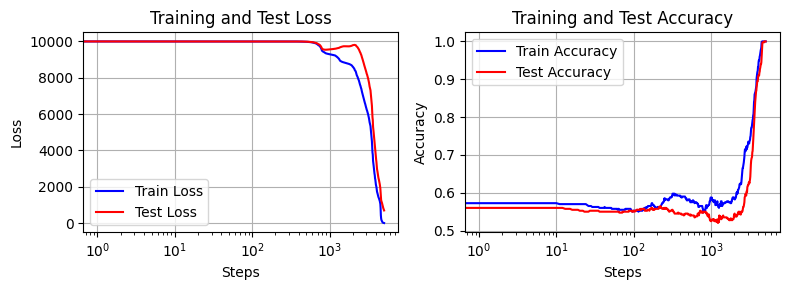

In [231]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

def load_dynamics_data(file_path):
    """
    Load dynamics data from a pickle file.

    Parameters:
    - file_path: The path to the pickle file containing the data.

    Returns:
    - A list of dynamics data entries.
    """
    with open(file_path, 'rb') as f:
        # Skip the HyperParams object
        pickle.load(f)

        # Read the remaining results
        results = []
        while True:
            try:
                result = pickle.load(f)
                results.append(result)
            except EOFError:
                break

    # Extract 'dynamics' from the results
    for result in results:
        if 'regular' in result and 'dynamics' in result['regular']:
            return result['regular']['dynamics']

    raise ValueError("No dynamics data found in the provided file.")

def plot_losses_and_errors(dynamics):
    """
    Plot training and test losses and errors from dynamics data.

    Parameters:
    - dynamics: A list of dynamics data entries.
    """
    if not dynamics:
        print("No dynamics data available.")
        return

    # Print the first and last entries
    print("First entry:", dynamics[0])
    print("Last entry:", dynamics[-1])

    steps = []
    train_losses = []
    test_losses = []
    train_errors = []
    test_errors = []
    train_accuracies = []
    test_accuracies = []

    for entry in dynamics:
        steps.append(entry['step'])

        # Extract loss and error values
        if 'train' in entry:
            train_losses.append(entry['train'].get('loss', None))
            train_errors.append(entry['train'].get('err', None))
            # Calculate accuracy from error
            train_accuracies.append(1 - entry['train'].get('err', 0))

        if 'test' in entry:
            test_losses.append(entry['test'].get('loss', None))
            test_errors.append(entry['test'].get('err', None))
            # Calculate accuracy from error
            test_accuracies.append(1 - entry['test'].get('err', 0))

    # Plot training and test losses
    plt.figure(figsize=(8, 3))

    plt.subplot(1, 2, 1)
    plt.plot(steps, train_losses, label='Train Loss', color='blue')
    plt.plot(steps, test_losses, label='Test Loss', color='red')
    plt.xscale('log')
    plt.xlabel('Steps')
    # plt.xlim(10 ** 2, np.max(steps))
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.grid(True)

    print(f"step len", len(steps))

    # Plot training and test accuracies
    plt.subplot(1, 2, 2)
    plt.plot(steps, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(steps, test_accuracies, label='Test Accuracy', color='red')
    plt.xscale('log')
    plt.xlabel('Steps')
    # plt.xlim(10 ** 2, np.max(steps))
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
file_path = 'F10k3Lsp_h_init/F10k3Lsp_h_init.pickle'
dynamics_data = load_dynamics_data(file_path)
plot_losses_and_errors(dynamics_data)

t 479
t max 328.13292968360673


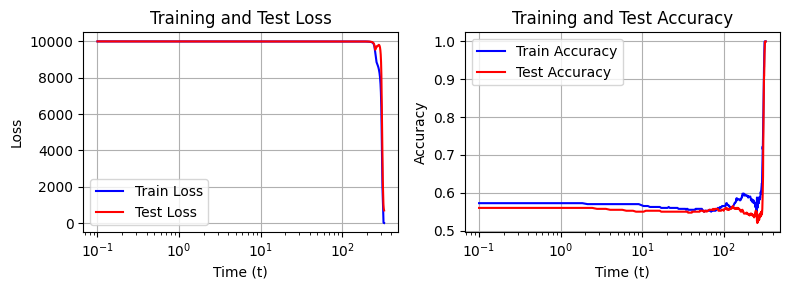

In [232]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

def load_dynamics_data(file_path):
    """
    Load dynamics data from a pickle file.

    Parameters:
    - file_path: The path to the pickle file containing the data.

    Returns:
    - A list of dynamics data entries.
    """
    with open(file_path, 'rb') as f:
        # Skip the HyperParams object
        pickle.load(f)

        # Read the remaining results
        results = []
        while True:
            try:
                result = pickle.load(f)
                results.append(result)
            except EOFError:
                break

    # Extract 'dynamics' from the results
    for result in results:
        if 'regular' in result and 'dynamics' in result['regular']:
            return result['regular']['dynamics']

    raise ValueError("No dynamics data found in the provided file.")

def plot_losses_and_errors(dynamics):
    """
    Plot training and test losses and errors from dynamics data.

    Parameters:
    - dynamics: A list of dynamics data entries.
    """
    times = []
    train_losses = []
    test_losses = []
    train_errors = []
    test_errors = []
    train_accuracies = []
    test_accuracies = []

    for entry in dynamics:
        times.append(entry['t'])

        # Extract loss and error values
        if 'train' in entry:
            train_losses.append(entry['train'].get('loss', None))
            train_errors.append(entry['train'].get('err', None))
            # Calculate accuracy from error
            train_accuracies.append(1 - entry['train'].get('err', 0))

        if 'test' in entry:
            test_losses.append(entry['test'].get('loss', None))
            test_errors.append(entry['test'].get('err', None))
            # Calculate accuracy from error
            test_accuracies.append(1 - entry['test'].get('err', 0))

    # Plot training and test losses
    plt.figure(figsize=(8, 3))

    plt.subplot(1, 2, 1)
    plt.semilogx(times, train_losses, label='Train Loss', color='blue')
    plt.semilogx(times, test_losses, label='Test Loss', color='red')
    plt.xlabel('Time (t)')
    # plt.xlim(10 ** 2, np.max(times))
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.grid(True)

    print(f"t", len(times))
    print(f"t max", np.max(times))

    # Plot training and test accuracies
    plt.subplot(1, 2, 2)
    plt.semilogx(times, train_accuracies, label='Train Accuracy', color='blue')
    plt.semilogx(times, test_accuracies, label='Test Accuracy', color='red')
    plt.xlabel('Time (t)')
    # plt.xlim(10 ** 2, np.max(times))
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
file_path = 'F10k3Lsp_h_init/F10k3Lsp_h_init.pickle'
dynamics_data = load_dynamics_data(file_path)
plot_losses_and_errors(dynamics_data)

# メイン (Adam)

In [241]:
import os
import torch
import copy
import itertools
from time import perf_counter
from functools import partial

class SplitEval(torch.nn.Module):
    def __init__(self, f, size):
        super().__init__()
        self.f = f
        self.size = size

    def forward(self, x):
        return torch.cat([self.f(x[i: i + self.size]) for i in range(0, len(x), self.size)])

def hinge(out, y, alpha):
    return (1 - alpha * out * y).relu().mean() / alpha

def quad_hinge(out, y, alpha):
    return 0.5 * (1 - alpha * out * y).relu().pow(2).mean() / alpha ** 2

def mse(out, y, alpha):
    return 0.5 * (1.1 - alpha * out * y).pow(2).mean() / alpha ** 2

def softhinge(out, y, alpha, beta):
    sp = partial(torch.nn.functional.softplus, beta=beta)
    return sp(1 - alpha * out * y).mean() / alpha

def cross_entropy(out, y, alpha):
    return torch.nn.functional.binary_cross_entropy_with_logits(out, (y + 1) / 2)

def run_regular(hyper, f0, loss, xtr, ytr, xte, yte):
    with torch.no_grad():
        otr0 = f0(xtr)
        ote0 = f0(xte)

    f = copy.deepcopy(f0)
    optimizer = torch.optim.Adam(f.parameters(), lr=hyper.learning_rate, weight_decay=hyper.weight_decay)

    dynamics = []
    checkpoint_generator = loglinspace(0.1, 1000)
    checkpoint = next(checkpoint_generator)
    wall = perf_counter()

    for step in range(hyper.max_steps):
        batch = torch.randperm(len(xtr))[:hyper.bs]
        xb = xtr[batch]

        loss_value = loss(f(xb) - otr0[batch], ytr[batch], hyper.alpha)

        if hyper.regularization == 'l1':
            l1_loss = sum(p.abs().sum() for p in f.parameters())
            loss_value += hyper.weight_decay * l1_loss

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        save = False

        if step == checkpoint:
            checkpoint = next(checkpoint_generator)
            assert checkpoint > step
            save = True

        if save:
            assert len(xtr) < len(xte)
            j = torch.randperm(len(xtr))

            with torch.no_grad():
                otr = f(xtr[j]) - otr0[j] if hyper.loss != 'cross_entropy' else f(xtr[j])
                ote = f(xte[j]) - ote0[j] if hyper.loss != 'cross_entropy' else f(xte[j])

            state = {
                'step': step,
                'wall': perf_counter() - wall,
                'batch_loss': loss_value.item(),
                'norm': sum(p.norm().pow(2) for p in f.parameters()).sqrt().item(),
                'dnorm': sum((p0 - p).norm().pow(2) for p0, p in zip(f0.parameters(), f.parameters())).sqrt().item(),
                'train': {
                    'loss': loss(otr, ytr[j], hyper.alpha).item(),
                    'aloss': hyper.alpha * loss(otr, ytr[j], hyper.alpha).item() if hyper.loss != 'cross_entropy' else loss(otr, ytr[j], hyper.alpha).item(),
                    'aaloss': hyper.alpha ** 2 * loss(otr, ytr[j], hyper.alpha).item() if hyper.loss != 'cross_entropy' else loss(otr, ytr[j], hyper.alpha).item(),
                    'err': (otr * ytr[j] <= 0).double().mean().item() if hyper.loss != 'cross_entropy' else ((otr > 0).float() != (ytr[j] + 1) / 2).float().mean().item(),
                    'nd': (hyper.alpha * otr * ytr[j] < 1).long().sum().item() if hyper.loss != 'cross_entropy' else 0,
                    'dfnorm': otr.pow(2).mean().sqrt(),
                    'fnorm': (otr + otr0[j]).pow(2).mean().sqrt() if hyper.loss != 'cross_entropy' else otr.pow(2).mean().sqrt(),
                },
                'test': {
                    'loss': loss(ote, yte[j], hyper.alpha).item(),
                    'aloss': hyper.alpha * loss(ote, yte[j], hyper.alpha).item() if hyper.loss != 'cross_entropy' else loss(ote, yte[j], hyper.alpha).item(),
                    'aaloss': hyper.alpha ** 2 * loss(ote, yte[j], hyper.alpha).item() if hyper.loss != 'cross_entropy' else loss(ote, yte[j], hyper.alpha).item(),
                    'err': (ote * yte[j] <= 0).double().mean().item() if hyper.loss != 'cross_entropy' else ((ote > 0).float() != (yte[j] + 1) / 2).float().mean().item(),
                    'nd': (hyper.alpha * ote * yte[j] < 1).long().sum().item() if hyper.loss != 'cross_entropy' else 0,
                    'dfnorm': ote.pow(2).mean().sqrt(),
                    'fnorm': (ote + ote0[j]).pow(2).mean().sqrt() if hyper.loss != 'cross_entropy' else ote.pow(2).mean().sqrt(),
                },
            }

            if hyper.arch.split('_')[0] == 'fc':
                def getw(f, i):
                    return torch.cat(list(getattr(f.f, "W{}".format(i))))
                state['wnorm'] = [getw(f, i).norm().item() for i in range(f.f.L + 1)]
                state['dwnorm'] = [(getw(f, i) - getw(f0, i)).norm().item() for i in range(f.f.L + 1)]

            print("[i={d[step]:d} wall={d[wall]:.0f}] [train aL={d[train][aloss]:.2e} err={d[train][err]:.2f} nd={d[train][nd]}/{p}] [test aL={d[test][aloss]:.2e} err={d[test][err]:.2f}]".format(d=state, p=len(j)), flush=True)

            dynamics.append(state)

            if hyper.loss != 'cross_entropy' and state['test']['nd'] == 0:
                break

        if perf_counter() > wall + hyper.train_time:
            break

    with torch.no_grad():
        otr = f(xtr) - otr0 if hyper.loss != 'cross_entropy' else f(xtr)
        ote = f(xte) - ote0 if hyper.loss != 'cross_entropy' else f(xte)

    out = {
        'dynamics': dynamics,
        'train': {
            'f0': otr0,
            'outputs': otr,
            'labels': ytr,
        },
        'test': {
            'f0': ote0,
            'outputs': ote,
            'labels': yte,
        }
    }
    return f, out

def run_exp(hyper, f0, xtr, ytr, xte, yte):
    run = {
        'hyper': hyper,
        'N': sum(p.numel() for p in f0.parameters()),
    }

    if hyper.loss == 'hinge':
        loss = hinge
    elif hyper.loss == 'quad_hinge':
        loss = quad_hinge
    elif hyper.loss == 'mse':
        loss = mse
    elif hyper.loss == 'softhinge':
        loss = partial(softhinge, beta=hyper.lossbeta)
    elif hyper.loss == 'cross_entropy':
        loss = cross_entropy
    else:
        raise ValueError(f"Invalid loss function: {hyper.loss}")

    _f, out = run_regular(hyper, f0, loss, xtr, ytr, xte, yte)
    run['regular'] = out

    yield run

class HyperParams:
    def __init__(self):
        self.device = 'cuda'
        self.dtype = 'float64'
        self.init_seed = 0
        self.batch_seed = 0
        self.n = 30
        self.k = 3
        self.train_size = 700
        self.test_size = 1000
        self.normalize = True
        self.data_seed = 0
        self.alpha = 1e-4
        self.f0 = 1
        self.tau_over_h = 1e-3
        self.tau_alpha_crit = 1e3
        self.L = 3
        self.h = 50
        self.arch = 'fc_softplus'
        self.spbeta = 5
        self.bs = 32
        self.bias = True
        self.max_dgrad = 1e-4
        self.max_dout = 0.1
        self.loss = 'cross_entropy'
        self.lossbeta = 20
        self.train_time = 18000
        self.chunk = 100
        self.init_kernel = 0
        self.delta_kernel = 0
        self.final_kernel = 0
        self.store_kernel = 0
        self.save_outputs = 0
        self.regular = 1
        self.directory = 'C10k3Lsp_adam'
        self.pickle = 'C10k3Lsp_adam.pickle'
        # 新しいハイパーパラメータ
        self.weight_decay = 2e-05
        self.learning_rate = 0.006
        self.max_steps = 10000
        self.regularization = 'l1'

import pickle

def run_and_save_experiment(hyper):
    if not os.path.exists(hyper.directory):
        os.makedirs(hyper.directory)

    pickle_path = os.path.join(hyper.directory, hyper.pickle)

    if hyper.test_size is None:
        hyper.test_size = hyper.train_size

    if hyper.chunk is None:
        hyper.chunk = hyper.train_size

    try:
        with open(pickle_path, 'wb') as f:
            pickle.dump(hyper, f)

        with open(pickle_path, 'ab') as f:
            for res in execute(hyper):
                pickle.dump(res, f)
    except Exception as e:
        if os.path.exists(pickle_path):
            os.remove(pickle_path)
        print(f"An error occurred during saving: {e}")
        raise e

######## 実験の実行と結果の保存
hyper = HyperParams()
run_and_save_experiment(hyper)

CUDA is not available. Running on CPU.
[i=0 wall=0] [train aL=7.10e-01 err=0.50 nd=0/700] [test aL=7.04e-01 err=0.48]
[i=1 wall=0] [train aL=7.10e-01 err=0.49 nd=0/700] [test aL=7.07e-01 err=0.48]
[i=2 wall=0] [train aL=7.11e-01 err=0.49 nd=0/700] [test aL=7.12e-01 err=0.47]
[i=3 wall=0] [train aL=7.12e-01 err=0.49 nd=0/700] [test aL=7.16e-01 err=0.49]
[i=4 wall=0] [train aL=7.11e-01 err=0.48 nd=0/700] [test aL=7.16e-01 err=0.49]
[i=5 wall=0] [train aL=7.11e-01 err=0.48 nd=0/700] [test aL=7.19e-01 err=0.49]
[i=6 wall=0] [train aL=7.11e-01 err=0.47 nd=0/700] [test aL=7.20e-01 err=0.49]
[i=7 wall=0] [train aL=7.10e-01 err=0.48 nd=0/700] [test aL=7.21e-01 err=0.49]
[i=8 wall=0] [train aL=7.07e-01 err=0.47 nd=0/700] [test aL=7.19e-01 err=0.49]
[i=9 wall=0] [train aL=7.05e-01 err=0.47 nd=0/700] [test aL=7.17e-01 err=0.48]
[i=10 wall=0] [train aL=7.03e-01 err=0.47 nd=0/700] [test aL=7.15e-01 err=0.48]
[i=11 wall=0] [train aL=7.02e-01 err=0.47 nd=0/700] [test aL=7.16e-01 err=0.47]
[i=13 wall=

In [246]:
import pickle

# ANSI escape sequences for colors
COLORS = {
    'HEADER': '\033[95m',  # Magenta
    'OKCYAN': '\033[96m',  # Cyan
    'OKGREEN': '\033[92m',  # Green
    'WARNING': '\033[93m',  # Yellow
    'FAIL': '\033[91m',    # Red
    'ENDC': '\033[0m',     # Reset to default
    'BOLD': '\033[1m',     # Bold
    'UNDERLINE': '\033[4m' # Underline
}

def color_text(text, color_name):
    return f"{COLORS[color_name]}{text}{COLORS['ENDC']}"

def load_and_print_summary(file_path, verbose=False):
    """
    保存された pickle ファイルを読み込み，その中身の概要を出力する関数

    Parameters:
    - file_path: 読み込む pickle ファイルのパス
    - verbose: データの詳細表示を行うかどうかのフラグ
    """
    try:
        with open(file_path, 'rb') as f:
            # 初めに HyperParams オブジェクトを読み込む
            hyper = pickle.load(f)

            # ハイパーパラメータの概要表示
            print(color_text(f"Loaded HyperParams object:", 'HEADER'))
            print(f"  Type: {type(hyper).__name__}")
            print(f"  Attributes:")
            for attribute in dir(hyper):
                if not attribute.startswith('__') and not callable(getattr(hyper, attribute)):
                    value = getattr(hyper, attribute)
                    print(f"    {attribute}: {value} ({type(value).__name__})")

            # 次に，実験結果が続く場合
            results = []
            while True:
                try:
                    result = pickle.load(f)
                    results.append(result)
                except EOFError:
                    break

            # 実験結果の概要を表示
            print(color_text("\nExperiment results summary:", 'OKCYAN'))
            print(f"  Number of results: {len(results)}")
            if len(results) > 0:
                if isinstance(results[0], dict):
                    print("  Sample keys from result dictionaries:")
                    sample_result = results[0]
                    sample_keys = {}
                    if isinstance(sample_result, dict):
                        for key, value in sample_result.items():
                            if isinstance(value, (list, dict)):
                                entry_count = len(value)
                                sample_keys[key] = (f"{entry_count} entries", type(value).__name__)
                            else:
                                sample_keys[key] = (f"{value}", type(value).__name__)
                    print(f"    Number of keys: {len(sample_keys)}")
                    for key, (entry_or_value, dtype) in sample_keys.items():
                        print(f"    {key}: {entry_or_value}, Type: {dtype}")
                else:
                    print(f"  Type of results: {type(results[0]).__name__}")

            # regular に含まれるキーとその数を表示
            if len(results) > 0 and isinstance(results[0], dict):
                regular_keys = set()
                key_data_counts = {}

                for result in results:
                    if 'regular' in result and isinstance(result['regular'], dict):
                        for key, value in result['regular'].items():
                            if key not in key_data_counts:
                                key_data_counts[key] = (0, None)
                            count, dtype = key_data_counts[key]
                            key_data_counts[key] = (count + 1, dtype if dtype else type(value).__name__)
                            regular_keys.add(key)

                print(color_text(f"\nKeys in 'regular' and their count:", 'OKGREEN'))
                print(f"  Number of keys: {len(key_data_counts)}")
                for key, (count, dtype) in key_data_counts.items():
                    print(f"    {key}: {count} entries, Type: {dtype}")

                # 各キー (dynamics, train, test) の詳細を表示
                for key in ['dynamics', 'train', 'test']:
                    if key in regular_keys:
                        if key == 'dynamics':
                            for i, dynamics_list in enumerate([result['regular'][key] for result in results if 'regular' in result and key in result['regular']], 1):
                                print(color_text(f"\nDetails of 'dynamics' list {i}:", 'HEADER'))
                                if len(dynamics_list) > 0 and isinstance(dynamics_list[0], dict):
                                    entry_description = {subkey: type(value).__name__ for subkey, value in dynamics_list[0].items()}
                                    print(f"  Example entry data types in 'dynamics' list {i}: {entry_description}")
                                print(f"  Number of entries in 'dynamics' list {i}: {len(dynamics_list)}")
                        else:
                            key_data_counts = {}
                            for result in results:
                                if 'regular' in result and key in result['regular']:
                                    if isinstance(result['regular'][key], dict):
                                        for subkey, value in result['regular'][key].items():
                                            if subkey not in key_data_counts:
                                                key_data_counts[subkey] = (0, None)
                                            count, dtype = key_data_counts[subkey]
                                            key_data_counts[subkey] = (count + 1, dtype if dtype else type(value).__name__)

                            print(color_text(f"\nKeys in 'regular[{key}]' and their count:", 'OKGREEN'))
                            print(f"  Number of keys: {len(key_data_counts)}")
                            for subkey, (count, dtype) in key_data_counts.items():
                                print(f"    {subkey}: {count} entries, Type: {dtype}")

                # dynamics 内の train と test キーのサブキーを表示
                if 'dynamics' in regular_keys:
                    dynamics_train_keys = {}
                    dynamics_test_keys = {}
                    for result in results:
                        if 'regular' in result and 'dynamics' in result['regular']:
                            for entry in result['regular']['dynamics']:
                                if isinstance(entry, dict):
                                    if 'train' in entry and isinstance(entry['train'], dict):
                                        for subkey, value in entry['train'].items():
                                            if subkey not in dynamics_train_keys:
                                                dynamics_train_keys[subkey] = (0, None)
                                            count, dtype = dynamics_train_keys[subkey]
                                            dynamics_train_keys[subkey] = (count + 1, dtype if dtype else type(value).__name__)
                                    if 'test' in entry and isinstance(entry['test'], dict):
                                        for subkey, value in entry['test'].items():
                                            if subkey not in dynamics_test_keys:
                                                dynamics_test_keys[subkey] = (0, None)
                                            count, dtype = dynamics_test_keys[subkey]
                                            dynamics_test_keys[subkey] = (count + 1, dtype if dtype else type(value).__name__)

                    print(color_text(f"\nKeys in 'dynamics[train]' and their count:", 'OKGREEN'))
                    print(f"  Number of keys: {len(dynamics_train_keys)}")
                    for subkey, (count, dtype) in dynamics_train_keys.items():
                        print(f"    {subkey}: {count} entries, Type: {dtype}")

                    print(color_text(f"\nKeys in 'dynamics[test]' and their count:", 'OKGREEN'))
                    print(f"  Number of keys: {len(dynamics_test_keys)}")
                    for subkey, (count, dtype) in dynamics_test_keys.items():
                        print(f"    {subkey}: {count} entries, Type: {dtype}")

            # 詳細なデータを表示（verbose が True の場合のみ）
            if verbose:
                print(color_text("\nLoaded experiment results:", 'HEADER'))
                for i, result in enumerate(results):
                    print(color_text(f"\nResult {i+1}:", 'HEADER'))
                    if isinstance(result, dict):
                        print(f"  Type: dict")
                        print(f"  Keys: {list(result.keys())}")
                        print(f"  All Values:")
                        for key in result.keys():
                            print(f"    {key}: {result[key]}")
                    else:
                        print(f"  Type: {type(result).__name__}")
                        print(f"  Content: {result}")

    except Exception as e:
        print(f"An error occurred while loading the file: {e}")

# 使用例
file_path = 'C10k3Lsp_adam/C10k3Lsp_adam.pickle'
load_and_print_summary(file_path, verbose=True)  # 詳細表示を無効にする場合

Loaded HyperParams object:
  Type: HyperParams
  Attributes:
    L: 3 (int)
    alpha: 0.0001 (float)
    arch: fc_softplus (str)
    batch_seed: 0 (int)
    bias: True (bool)
    bs: 32 (int)
    chunk: 100 (int)
    data_seed: 0 (int)
    delta_kernel: 0 (int)
    device: cuda (str)
    directory: C10k3Lsp_adam (str)
    dtype: float64 (str)
    f0: 1 (int)
    final_kernel: 0 (int)
    h: 50 (int)
    init_kernel: 0 (int)
    init_seed: 0 (int)
    k: 3 (int)
    learning_rate: 0.006 (float)
    loss: cross_entropy (str)
    lossbeta: 20 (int)
    max_dgrad: 0.0001 (float)
    max_dout: 0.1 (float)
    max_steps: 10000 (int)
    n: 30 (int)
    normalize: True (bool)
    pickle: C10k3Lsp_adam.pickle (str)
    regular: 1 (int)
    regularization: l1 (str)
    save_outputs: 0 (int)
    spbeta: 5 (int)
    store_kernel: 0 (int)
    tau_alpha_crit: 1000.0 (float)
    tau_over_h: 0.001 (float)
    test_size: 1000 (int)
    train_size: 700 (int)
    train_time: 18000 (int)
    weight_deca

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


First entry: {'step': 0, 'wall': 0.01184870100041735, 'batch_loss': 0.7968352136670752, 'norm': 80.4820279441315, 'dnorm': 0.49106236378435025, 'train': {'loss': 0.7097318003053928, 'aloss': 0.7097318003053928, 'aaloss': 0.7097318003053928, 'err': 0.49714285135269165, 'nd': 0, 'dfnorm': tensor(0.3723), 'fnorm': tensor(0.3723)}, 'test': {'loss': 0.7035889364935375, 'aloss': 0.7035889364935375, 'aaloss': 0.7035889364935375, 'err': 0.4814285635948181, 'nd': 0, 'dfnorm': tensor(0.3714), 'fnorm': tensor(0.3714)}, 'wnorm': [39.05115856885033, 49.396493420512364, 49.82594658141633, 5.45159479580254], 'dwnorm': [0.23234094148568268, 0.29996399522477873, 0.2999099302735704, 0.04242559785271834]}
Last entry: {'step': 9640, 'wall': 32.14731873200071, 'batch_loss': 0.0051474246183460005, 'norm': 28.6719981629486, 'dnorm': 83.6087781083084, 'train': {'loss': 0.0006983444486166438, 'aloss': 0.0006983444486166438, 'aaloss': 0.0006983444486166438, 'err': 0.0, 'nd': 0, 'dfnorm': tensor(7.3493), 'fnorm'

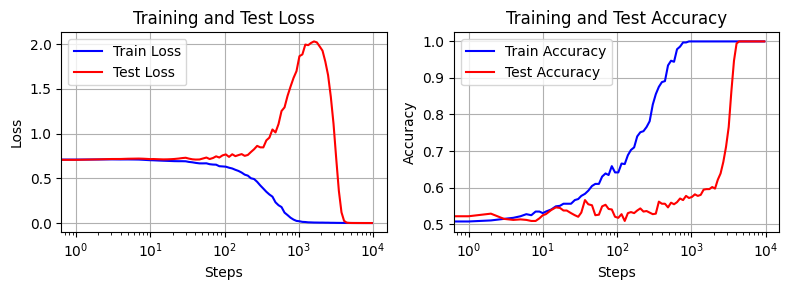

In [247]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

def load_dynamics_data(file_path):
    """
    Load dynamics data from a pickle file.

    Parameters:
    - file_path: The path to the pickle file containing the data.

    Returns:
    - A list of dynamics data entries.
    """
    with open(file_path, 'rb') as f:
        # Skip the HyperParams object
        pickle.load(f)

        # Read the remaining results
        results = []
        while True:
            try:
                result = pickle.load(f)
                results.append(result)
            except EOFError:
                break

    # Extract 'dynamics' from the results
    for result in results:
        if 'regular' in result and 'dynamics' in result['regular']:
            return result['regular']['dynamics']

    raise ValueError("No dynamics data found in the provided file.")

def plot_losses_and_errors(dynamics):
    """
    Plot training and test losses and errors from dynamics data.

    Parameters:
    - dynamics: A list of dynamics data entries.
    """
    if not dynamics:
        print("No dynamics data available.")
        return

    # Print the first and last entries
    print("First entry:", dynamics[0])
    print("Last entry:", dynamics[-1])

    steps = []
    train_losses = []
    test_losses = []
    train_errors = []
    test_errors = []
    train_accuracies = []
    test_accuracies = []

    for entry in dynamics:
        steps.append(entry['step'])

        # Extract loss and error values
        if 'train' in entry:
            train_losses.append(entry['train'].get('loss', None))
            train_errors.append(entry['train'].get('err', None))
            # Calculate accuracy from error
            train_accuracies.append(1 - entry['train'].get('err', 0))

        if 'test' in entry:
            test_losses.append(entry['test'].get('loss', None))
            test_errors.append(entry['test'].get('err', None))
            # Calculate accuracy from error
            test_accuracies.append(1 - entry['test'].get('err', 0))

    # Plot training and test losses
    plt.figure(figsize=(8, 3))

    plt.subplot(1, 2, 1)
    plt.plot(steps, train_losses, label='Train Loss', color='blue')
    plt.plot(steps, test_losses, label='Test Loss', color='red')
    plt.xscale('log')
    plt.xlabel('Steps')
    # plt.xlim(10 ** 2, np.max(steps))
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.grid(True)

    print(f"step len", len(steps))

    # Plot training and test accuracies
    plt.subplot(1, 2, 2)
    plt.plot(steps, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(steps, test_accuracies, label='Test Accuracy', color='red')
    plt.xscale('log')
    plt.xlabel('Steps')
    # plt.xlim(10 ** 2, np.max(steps))
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
file_path = 'C10k3Lsp_adam/C10k3Lsp_adam.pickle'
dynamics_data = load_dynamics_data(file_path)
plot_losses_and_errors(dynamics_data)